## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp031'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

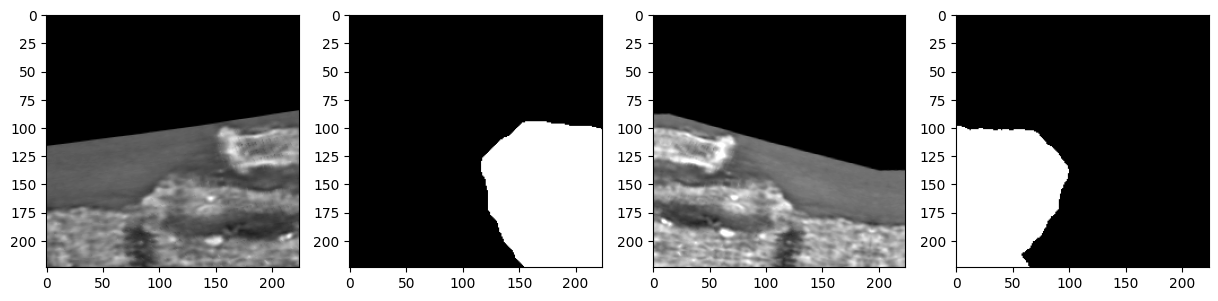

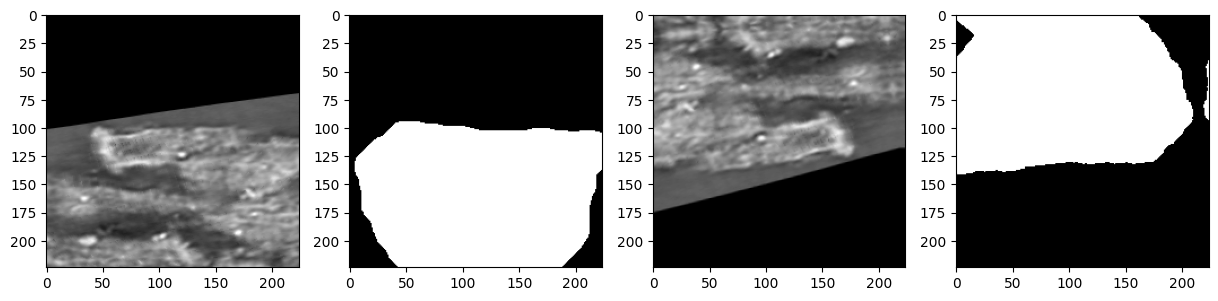

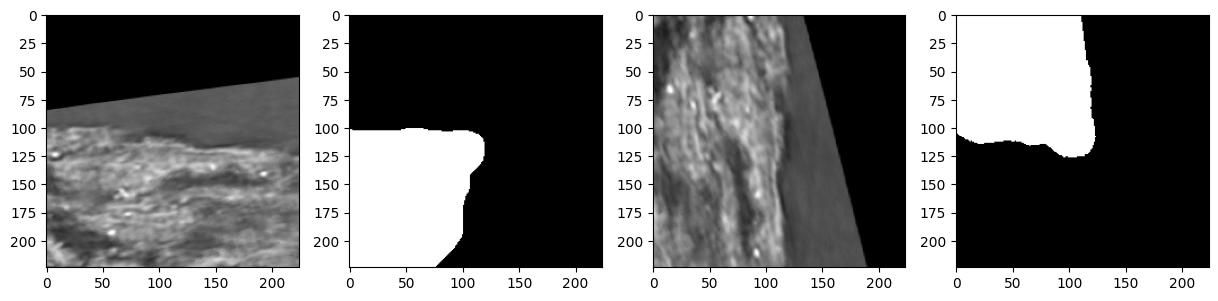

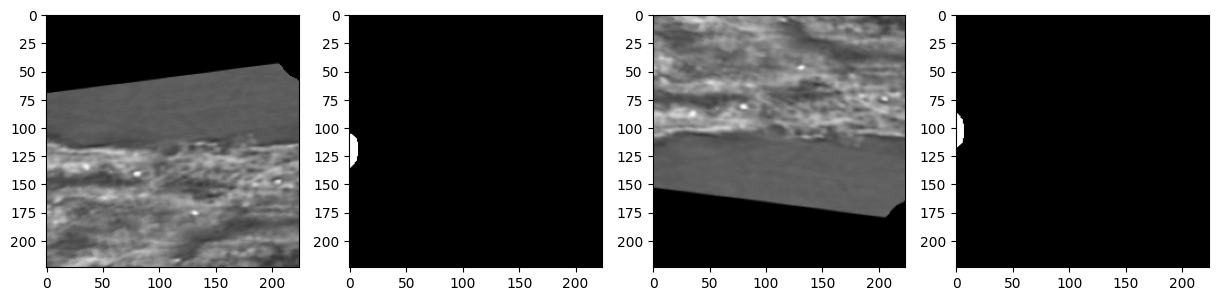

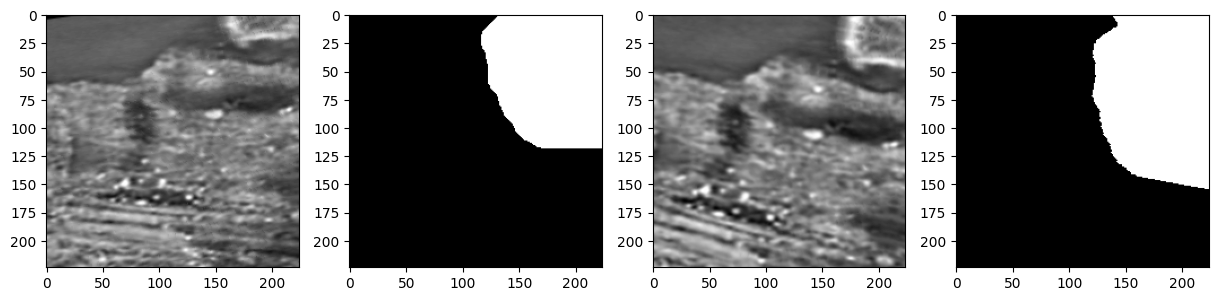

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53880

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    # return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501674027896888
th: 0.15, fbeta: 0.09506560237194964
th: 0.2, fbeta: 0.1362868379377932
th: 0.25, fbeta: 0.15254108226813373
th: 0.3, fbeta: 0.17611018296558986
th: 0.35, fbeta: 0.20443185433111485
th: 0.4, fbeta: 0.24204693214049772
th: 0.45, fbeta: 0.283739535997821


best_th: 0.5, fbeta: 0.32469226787517186
Epoch 1 - avg_train_loss: 0.6951  avg_val_loss: 0.5279  time: 157s
Epoch 1 - avgScore: 0.3247
Epoch 1 - Save Best Score: 0.3247 Model
Epoch 1 - Save Best Loss: 0.5279 Model


th: 0.5, fbeta: 0.32469226787517186


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09506087181799852
th: 0.15, fbeta: 0.14646108524256068
th: 0.2, fbeta: 0.18326432738222434
th: 0.25, fbeta: 0.2397594448556909
th: 0.3, fbeta: 0.2842901037819767
th: 0.35, fbeta: 0.32078250487651544
th: 0.4, fbeta: 0.3525623332904826
th: 0.45, fbeta: 0.3821654380249417


best_th: 0.5, fbeta: 0.41095299799092655
Epoch 2 - avg_train_loss: 0.5877  avg_val_loss: 0.4662  time: 160s
Epoch 2 - avgScore: 0.4110
Epoch 2 - Save Best Score: 0.4110 Model
Epoch 2 - Save Best Loss: 0.4662 Model


th: 0.5, fbeta: 0.41095299799092655


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2955176579079425
th: 0.15, fbeta: 0.32860788725305473
th: 0.2, fbeta: 0.3542446284953239
th: 0.25, fbeta: 0.3778438764085185
th: 0.3, fbeta: 0.39808055748837534
th: 0.35, fbeta: 0.4166546852426611
th: 0.4, fbeta: 0.432735029864624
th: 0.45, fbeta: 0.4487106962738151


best_th: 0.5, fbeta: 0.4627501322183087
Epoch 3 - avg_train_loss: 0.5061  avg_val_loss: 0.3677  time: 162s
Epoch 3 - avgScore: 0.4628
Epoch 3 - Save Best Score: 0.4628 Model
Epoch 3 - Save Best Loss: 0.3677 Model


th: 0.5, fbeta: 0.4627501322183087


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2630810918068281
th: 0.15, fbeta: 0.2803713658476824
th: 0.2, fbeta: 0.29446864068447853
th: 0.25, fbeta: 0.3097596417152614
th: 0.3, fbeta: 0.32406350579643695
th: 0.35, fbeta: 0.33530202320545605
th: 0.4, fbeta: 0.3457723925051249
th: 0.45, fbeta: 0.3564976077636929


best_th: 0.5, fbeta: 0.36937457760395526
Epoch 4 - avg_train_loss: 0.4483  avg_val_loss: 0.4283  time: 162s
Epoch 4 - avgScore: 0.3694


th: 0.5, fbeta: 0.36937457760395526


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33212652101475826
th: 0.15, fbeta: 0.36151181286269635
th: 0.2, fbeta: 0.3870241924183184
th: 0.25, fbeta: 0.40950342811377183
th: 0.3, fbeta: 0.4300983887042843
th: 0.35, fbeta: 0.44951712529948706
th: 0.4, fbeta: 0.4680633974743245
th: 0.45, fbeta: 0.48591079134011733


best_th: 0.5, fbeta: 0.5014766575784299
Epoch 5 - avg_train_loss: 0.4161  avg_val_loss: 0.3448  time: 162s
Epoch 5 - avgScore: 0.5015
Epoch 5 - Save Best Score: 0.5015 Model
Epoch 5 - Save Best Loss: 0.3448 Model


th: 0.5, fbeta: 0.5014766575784299


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2597367640022364
th: 0.15, fbeta: 0.28773530404668685
th: 0.2, fbeta: 0.3051854695881154
th: 0.25, fbeta: 0.3207281181155964
th: 0.3, fbeta: 0.3356529819476336
th: 0.35, fbeta: 0.34949934584054526
th: 0.4, fbeta: 0.364532153250276
th: 0.45, fbeta: 0.38004298039356427


best_th: 0.5, fbeta: 0.39566214272011185
Epoch 6 - avg_train_loss: 0.4011  avg_val_loss: 0.4080  time: 164s
Epoch 6 - avgScore: 0.3957


th: 0.5, fbeta: 0.39566214272011185


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4290577083723296
th: 0.15, fbeta: 0.4584754138136042
th: 0.2, fbeta: 0.4815430659194636
th: 0.25, fbeta: 0.502786135877872
th: 0.3, fbeta: 0.5197007540334134
th: 0.35, fbeta: 0.5323714605810964
th: 0.4, fbeta: 0.5448428206686976


best_th: 0.5, fbeta: 0.5710521913517769
Epoch 7 - avg_train_loss: 0.3991  avg_val_loss: 0.3403  time: 162s
Epoch 7 - avgScore: 0.5711
Epoch 7 - Save Best Score: 0.5711 Model
Epoch 7 - Save Best Loss: 0.3403 Model


th: 0.45, fbeta: 0.5591671888170358
th: 0.5, fbeta: 0.5710521913517769


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3024918814769548
th: 0.15, fbeta: 0.3255806189334788
th: 0.2, fbeta: 0.34401427265092205
th: 0.25, fbeta: 0.3611359205382765
th: 0.3, fbeta: 0.37951920232928704
th: 0.35, fbeta: 0.3959344240643206
th: 0.4, fbeta: 0.4121084391837126
th: 0.45, fbeta: 0.42918067486628275


best_th: 0.5, fbeta: 0.4443814562794134
Epoch 8 - avg_train_loss: 0.3620  avg_val_loss: 0.3768  time: 162s
Epoch 8 - avgScore: 0.4444


th: 0.5, fbeta: 0.4443814562794134


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3123612117804181
th: 0.15, fbeta: 0.33368801790866415
th: 0.2, fbeta: 0.3500493448699122
th: 0.25, fbeta: 0.36560359103519263
th: 0.3, fbeta: 0.38208261698078316
th: 0.35, fbeta: 0.39555406749373695
th: 0.4, fbeta: 0.4081623268790091
th: 0.45, fbeta: 0.4222072666669253


best_th: 0.5, fbeta: 0.43660872115668886
Epoch 9 - avg_train_loss: 0.3463  avg_val_loss: 0.3880  time: 161s
Epoch 9 - avgScore: 0.4366


th: 0.5, fbeta: 0.43660872115668886


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4174170917849522
th: 0.15, fbeta: 0.4466716379604404
th: 0.2, fbeta: 0.46765069147616617
th: 0.25, fbeta: 0.48482323740843375
th: 0.3, fbeta: 0.499721135571691
th: 0.35, fbeta: 0.5092645147737042
th: 0.4, fbeta: 0.514177854551323
th: 0.45, fbeta: 0.5190459587824157


best_th: 0.5, fbeta: 0.5249217386072553
Epoch 10 - avg_train_loss: 0.3466  avg_val_loss: 0.3691  time: 160s
Epoch 10 - avgScore: 0.5249


th: 0.5, fbeta: 0.5249217386072553


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34754701492634005
th: 0.15, fbeta: 0.36619654836492493
th: 0.2, fbeta: 0.3839056975577726
th: 0.25, fbeta: 0.40172116005280684
th: 0.3, fbeta: 0.41789634623354577
th: 0.35, fbeta: 0.43132899294341875
th: 0.4, fbeta: 0.4447824984946975
th: 0.45, fbeta: 0.45886937426644064


best_th: 0.5, fbeta: 0.47495795190931356
Epoch 11 - avg_train_loss: 0.3275  avg_val_loss: 0.3710  time: 162s
Epoch 11 - avgScore: 0.4750


th: 0.5, fbeta: 0.47495795190931356


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33935626172613037
th: 0.15, fbeta: 0.35868971859085047
th: 0.2, fbeta: 0.3753147323770837
th: 0.25, fbeta: 0.3947186140455246
th: 0.3, fbeta: 0.41139844937923326
th: 0.35, fbeta: 0.4262020092353087
th: 0.4, fbeta: 0.44004647388802987
th: 0.45, fbeta: 0.45475016153260583


best_th: 0.5, fbeta: 0.47044716215212434
Epoch 12 - avg_train_loss: 0.2935  avg_val_loss: 0.3799  time: 161s
Epoch 12 - avgScore: 0.4704


th: 0.5, fbeta: 0.47044716215212434


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3825543061399366
th: 0.15, fbeta: 0.4020736815492989
th: 0.2, fbeta: 0.4175892992798598
th: 0.25, fbeta: 0.4394141030411251
th: 0.3, fbeta: 0.46028343453884646
th: 0.35, fbeta: 0.4736501992013926
th: 0.4, fbeta: 0.48598421866008473
th: 0.45, fbeta: 0.5003907062309513


best_th: 0.5, fbeta: 0.5136953390851307
Epoch 13 - avg_train_loss: 0.2939  avg_val_loss: 0.3722  time: 160s
Epoch 13 - avgScore: 0.5137


th: 0.5, fbeta: 0.5136953390851307


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30142395794943666
th: 0.15, fbeta: 0.3198397854327407
th: 0.2, fbeta: 0.3356393290611265
th: 0.25, fbeta: 0.35401804698352607
th: 0.3, fbeta: 0.3707775641875425
th: 0.35, fbeta: 0.38447524418693446
th: 0.4, fbeta: 0.3972837096271538
th: 0.45, fbeta: 0.41216060641830876


best_th: 0.5, fbeta: 0.4289612318470475
Epoch 14 - avg_train_loss: 0.2910  avg_val_loss: 0.3948  time: 160s
Epoch 14 - avgScore: 0.4290


th: 0.5, fbeta: 0.4289612318470475


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4064260837527953
th: 0.15, fbeta: 0.4227673332998512
th: 0.2, fbeta: 0.43834915084042264
th: 0.25, fbeta: 0.46135551049678547
th: 0.3, fbeta: 0.47624504138655926
th: 0.35, fbeta: 0.48701573145078525
th: 0.4, fbeta: 0.49775156180038577
th: 0.45, fbeta: 0.5097710195098495


best_th: 0.5, fbeta: 0.5227976748546471
Epoch 15 - avg_train_loss: 0.2674  avg_val_loss: 0.3774  time: 160s
Epoch 15 - avgScore: 0.5228


th: 0.5, fbeta: 0.5227976748546471


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32354718500256036
th: 0.15, fbeta: 0.3413208450135838
th: 0.2, fbeta: 0.35841982738657335
th: 0.25, fbeta: 0.3807983853700558
th: 0.3, fbeta: 0.3973223557948685
th: 0.35, fbeta: 0.4095554924306684
th: 0.4, fbeta: 0.42193283026521883
th: 0.45, fbeta: 0.4369816936926219


best_th: 0.5, fbeta: 0.45363695663263315
Epoch 16 - avg_train_loss: 0.2466  avg_val_loss: 0.3878  time: 160s
Epoch 16 - avgScore: 0.4536


th: 0.5, fbeta: 0.45363695663263315


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40464895850715177
th: 0.15, fbeta: 0.42160697130064184
th: 0.2, fbeta: 0.4421567199232737
th: 0.25, fbeta: 0.4716661327634904
th: 0.3, fbeta: 0.4894813525802407
th: 0.35, fbeta: 0.5012822753252502
th: 0.4, fbeta: 0.5122935854027098
th: 0.45, fbeta: 0.524786291862684


best_th: 0.5, fbeta: 0.5351437103328107
Epoch 17 - avg_train_loss: 0.2355  avg_val_loss: 0.3761  time: 159s
Epoch 17 - avgScore: 0.5351


th: 0.5, fbeta: 0.5351437103328107


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44246306465430296
th: 0.15, fbeta: 0.4601143785222968
th: 0.2, fbeta: 0.4777867075886966
th: 0.25, fbeta: 0.5042001246543631
th: 0.3, fbeta: 0.5213245986334984
th: 0.35, fbeta: 0.5308407550267912
th: 0.4, fbeta: 0.5399932688555084
th: 0.45, fbeta: 0.5506687927072056


best_th: 0.5, fbeta: 0.5627532361567285
Epoch 18 - avg_train_loss: 0.2379  avg_val_loss: 0.3662  time: 160s
Epoch 18 - avgScore: 0.5628


th: 0.5, fbeta: 0.5627532361567285


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37640175485131017
th: 0.15, fbeta: 0.39531082905022163
th: 0.2, fbeta: 0.41295946963494956
th: 0.25, fbeta: 0.43813775193565513
th: 0.3, fbeta: 0.4591403244278554
th: 0.35, fbeta: 0.4736598306923536
th: 0.4, fbeta: 0.48642783539009604
th: 0.45, fbeta: 0.5001379959869399


best_th: 0.5, fbeta: 0.5120722969500012
Epoch 19 - avg_train_loss: 0.2222  avg_val_loss: 0.3739  time: 160s
Epoch 19 - avgScore: 0.5121


th: 0.5, fbeta: 0.5120722969500012


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3660722433562716
th: 0.15, fbeta: 0.38262906444702743
th: 0.2, fbeta: 0.4000187972666396
th: 0.25, fbeta: 0.42671826679522007
th: 0.3, fbeta: 0.4481003260576508
th: 0.35, fbeta: 0.4614884362551578
th: 0.4, fbeta: 0.47412883615838963
th: 0.45, fbeta: 0.4885350631675665


best_th: 0.5, fbeta: 0.5087570088835563
Epoch 20 - avg_train_loss: 0.2131  avg_val_loss: 0.3815  time: 160s
Epoch 20 - avgScore: 0.5088


th: 0.5, fbeta: 0.5087570088835563


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4096800993518455
th: 0.15, fbeta: 0.4263143378172035
th: 0.2, fbeta: 0.44310065567992074
th: 0.25, fbeta: 0.46919206920522655
th: 0.3, fbeta: 0.4912583243981186
th: 0.35, fbeta: 0.5027166408973991
th: 0.4, fbeta: 0.5144474747923474
th: 0.45, fbeta: 0.5263834089194416


best_th: 0.5, fbeta: 0.5457156833165113
Epoch 21 - avg_train_loss: 0.2001  avg_val_loss: 0.3766  time: 162s
Epoch 21 - avgScore: 0.5457


th: 0.5, fbeta: 0.5457156833165113


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35291133371582284
th: 0.15, fbeta: 0.3689440873985061
th: 0.2, fbeta: 0.38629757295099765
th: 0.25, fbeta: 0.4110421447531527
th: 0.3, fbeta: 0.4273687886395091
th: 0.35, fbeta: 0.4390313406204424
th: 0.4, fbeta: 0.4519956440094959
th: 0.45, fbeta: 0.46879921623423515


best_th: 0.5, fbeta: 0.49286660446266667
Epoch 22 - avg_train_loss: 0.1990  avg_val_loss: 0.3923  time: 162s
Epoch 22 - avgScore: 0.4929


th: 0.5, fbeta: 0.49286660446266667


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36130577269886155
th: 0.15, fbeta: 0.3786299367407244
th: 0.2, fbeta: 0.3947954662109138
th: 0.25, fbeta: 0.4176918511531926
th: 0.3, fbeta: 0.4378901477170972
th: 0.35, fbeta: 0.4492365423707774
th: 0.4, fbeta: 0.45988757933939467
th: 0.45, fbeta: 0.47430079157653


best_th: 0.5, fbeta: 0.4913452875107459
Epoch 23 - avg_train_loss: 0.1917  avg_val_loss: 0.3885  time: 164s
Epoch 23 - avgScore: 0.4913


th: 0.5, fbeta: 0.4913452875107459


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3961916146473962
th: 0.15, fbeta: 0.4118638154226206
th: 0.2, fbeta: 0.430109991259289
th: 0.25, fbeta: 0.45923410595991265
th: 0.3, fbeta: 0.47964243527143
th: 0.35, fbeta: 0.4901263287066075
th: 0.4, fbeta: 0.5001372266483094
th: 0.45, fbeta: 0.5139833949282105


best_th: 0.5, fbeta: 0.537273796981726
Epoch 24 - avg_train_loss: 0.1774  avg_val_loss: 0.3804  time: 162s
Epoch 24 - avgScore: 0.5373


th: 0.5, fbeta: 0.537273796981726


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39362343881132356
th: 0.15, fbeta: 0.4080415668293328
th: 0.2, fbeta: 0.42344854368437485
th: 0.25, fbeta: 0.45189646459093163
th: 0.3, fbeta: 0.47247613942351246
th: 0.35, fbeta: 0.48330598832746635
th: 0.4, fbeta: 0.493380685936578
th: 0.45, fbeta: 0.5080173779781594


best_th: 0.5, fbeta: 0.5272944197090232
Epoch 25 - avg_train_loss: 0.1751  avg_val_loss: 0.3976  time: 163s
Epoch 25 - avgScore: 0.5273


th: 0.5, fbeta: 0.5272944197090232


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.382561820135091
th: 0.15, fbeta: 0.396265676449362
th: 0.2, fbeta: 0.41211102369138136
th: 0.25, fbeta: 0.4412624981528625
th: 0.3, fbeta: 0.4611445654793974
th: 0.35, fbeta: 0.472337353586641
th: 0.4, fbeta: 0.48285633641534403
th: 0.45, fbeta: 0.4954709726381412


best_th: 0.5, fbeta: 0.5191285504291058
Epoch 26 - avg_train_loss: 0.1716  avg_val_loss: 0.3937  time: 162s
Epoch 26 - avgScore: 0.5191


th: 0.5, fbeta: 0.5191285504291058


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37058201552629494
th: 0.15, fbeta: 0.3847374406303369
th: 0.2, fbeta: 0.4017317776892481
th: 0.25, fbeta: 0.43246093619673476
th: 0.3, fbeta: 0.45311874233193816
th: 0.35, fbeta: 0.4657356294617538
th: 0.4, fbeta: 0.4775925190492163
th: 0.45, fbeta: 0.49385751190307103


best_th: 0.5, fbeta: 0.5162278835616573
Epoch 27 - avg_train_loss: 0.1652  avg_val_loss: 0.3912  time: 161s
Epoch 27 - avgScore: 0.5162


th: 0.5, fbeta: 0.5162278835616573


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4164300201381835
th: 0.15, fbeta: 0.43106712376831213
th: 0.2, fbeta: 0.44805546113818273
th: 0.25, fbeta: 0.47556354810253115
th: 0.3, fbeta: 0.491147521209862
th: 0.35, fbeta: 0.5006803906331904
th: 0.4, fbeta: 0.5104580731013493
th: 0.45, fbeta: 0.5261695950323498


best_th: 0.5, fbeta: 0.5467001217470702
Epoch 28 - avg_train_loss: 0.1661  avg_val_loss: 0.3940  time: 161s
Epoch 28 - avgScore: 0.5467


th: 0.5, fbeta: 0.5467001217470702


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.385160043567119
th: 0.15, fbeta: 0.39845230996856223
th: 0.2, fbeta: 0.4155181070915768
th: 0.25, fbeta: 0.44628010745410174
th: 0.3, fbeta: 0.4659562305470538
th: 0.35, fbeta: 0.475617538745014
th: 0.4, fbeta: 0.4852421793208218
th: 0.45, fbeta: 0.4998328645213814


best_th: 0.5, fbeta: 0.527405925552145
Epoch 29 - avg_train_loss: 0.1630  avg_val_loss: 0.3958  time: 163s
Epoch 29 - avgScore: 0.5274


th: 0.5, fbeta: 0.527405925552145


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39076299095339545
th: 0.15, fbeta: 0.4058406334126779
th: 0.2, fbeta: 0.4221185845678779
th: 0.25, fbeta: 0.45005685170833265
th: 0.3, fbeta: 0.47048533533177933
th: 0.35, fbeta: 0.48074708909075253
th: 0.4, fbeta: 0.4902852068908494
th: 0.45, fbeta: 0.503687595045405


best_th: 0.5, fbeta: 0.5277433997747183
Epoch 30 - avg_train_loss: 0.1619  avg_val_loss: 0.3923  time: 163s
Epoch 30 - avgScore: 0.5277


th: 0.5, fbeta: 0.5277433997747183


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4290577083723296
th: 0.15, fbeta: 0.4584754138136042
th: 0.2, fbeta: 0.4815430659194636
th: 0.25, fbeta: 0.502786135877872
th: 0.3, fbeta: 0.5197007540334134
th: 0.35, fbeta: 0.5323714605810964
th: 0.4, fbeta: 0.5448428206686976
th: 0.45, fbeta: 0.5591671888170358


best_th: 0.5, fbeta: 0.5710521913517769


th: 0.5, fbeta: 0.5710521913517769


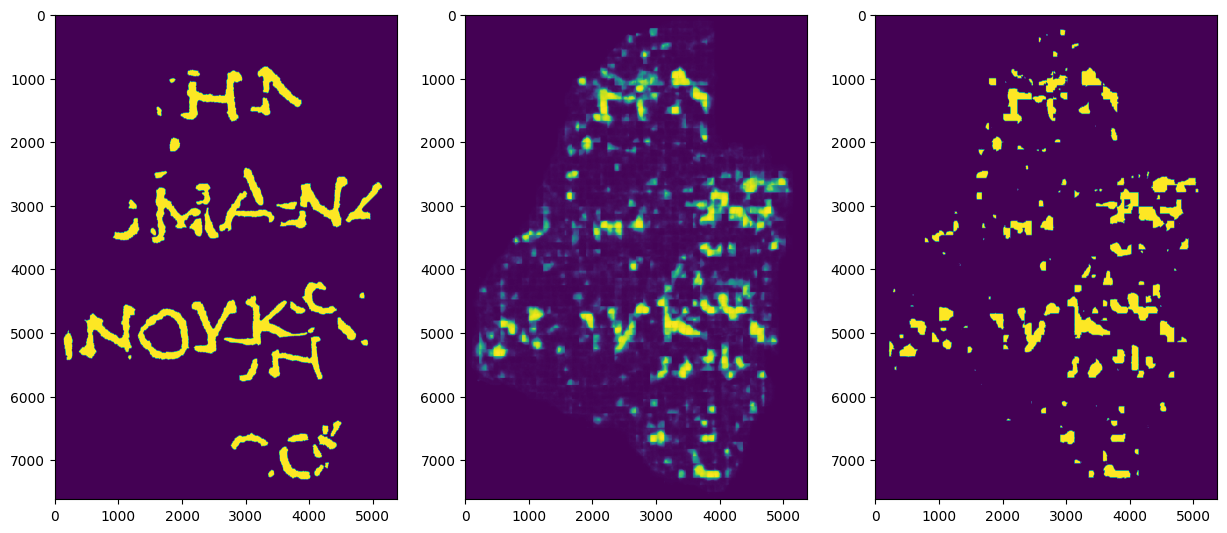

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([32565987.,  2730451.,   720710.,   497267.,   448407.,   401443.,
          308061.,   290166.,   313448.,   306571.,   229777.,   178939.,
          170102.,   174844.,   160859.,   152099.,   182360.,   253927.,
          388082.,   470116.]),
 array([4.65838679e-06, 4.99308100e-02, 9.98569616e-02, 1.49783113e-01,
        1.99709265e-01, 2.49635416e-01, 2.99561568e-01, 3.49487720e-01,
        3.99413871e-01, 4.49340023e-01, 4.99266175e-01, 5.49192326e-01,
        5.99118478e-01, 6.49044629e-01, 6.98970781e-01, 7.48896933e-01,
        7.98823084e-01, 8.48749236e-01, 8.98675388e-01, 9.48601539e-01,
        9.98527691e-01]),
 <BarContainer object of 20 artists>)

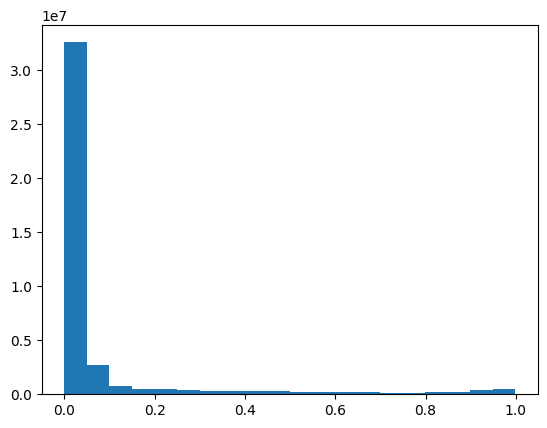

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000